# Imports

In [ ]:
! pip install face_recognition

     |████████████████████████████████| 100.1 MB 1.1 MB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=0c4ba65ea07aec34558dd566e83b9e67777e2996d7650889a3fb7ef4f6c9fca4
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [ ]:
import os
import sys
import shutil
import re
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2

import face_recognition

# Reading the Dataset

In [ ]:
base_path = '/content/drive/MyDrive/ml-project/'
meld_path = base_path + 'MELD.Raw'

In [ ]:
!ls drive/MyDrive/ml-project/MELD.Raw/train_splits

dia0_utt0.mp4	   dia298_utt3.mp4   dia532_utt11.mp4  dia771_utt9.mp4
dia0_utt10.mp4	   dia298_utt4.mp4   dia532_utt12.mp4  dia772_utt0.mp4
dia0_utt11.mp4	   dia298_utt5.mp4   dia532_utt13.mp4  dia772_utt10.mp4
dia0_utt12.mp4	   dia298_utt6.mp4   dia532_utt14.mp4  dia772_utt11.mp4
dia0_utt13.mp4	   dia299_utt0.mp4   dia532_utt15.mp4  dia772_utt12.mp4
dia0_utt1.mp4	   dia299_utt1.mp4   dia532_utt1.mp4   dia772_utt13.mp4
dia0_utt2.mp4	   dia299_utt2.mp4   dia532_utt2.mp4   dia772_utt14.mp4
dia0_utt3.mp4	   dia299_utt3.mp4   dia532_utt3.mp4   dia772_utt15.mp4
dia0_utt4.mp4	   dia29_utt0.mp4    dia532_utt4.mp4   dia772_utt1.mp4
dia0_utt5.mp4	   dia29_utt10.mp4   dia532_utt5.mp4   dia772_utt2.mp4
dia0_utt6.mp4	   dia29_utt11.mp4   dia532_utt6.mp4   dia772_utt3.mp4
dia0_utt7.mp4	   dia29_utt12.mp4   dia532_utt7.mp4   dia772_utt4.mp4
dia0_utt8.mp4	   dia29_utt13.mp4   dia532_utt8.mp4   dia772_utt5.mp4
dia0_utt9.mp4	   dia29_utt1.mp4    dia532_utt9.mp4   dia772_utt6.mp4
dia1000_utt0.mp4   dia29

In [ ]:
def re_create_dirs(output_directory):
    # Check if the directory exists, otherwise create directory
    try:
        if os.path.exists(output_directory):
            shutil.rmtree(output_directory)
            
        os.makedirs(output_directory)
    except OSError:
        print('Error: Creating directory {} of data'.format(output_directory))

In [ ]:
df = pd.read_csv(meld_path + '/train_sent_emo.csv')
df

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"
...,...,...,...,...,...,...,...,...,...,...,...
9984,10474,You or me?,Chandler,neutral,neutral,1038,13,2,3,"00:00:48,173","00:00:50,799"
9985,10475,"I got it. Uh, Joey, women don't have Adam's ap...",Ross,neutral,neutral,1038,14,2,3,"00:00:51,009","00:00:53,594"
9986,10476,"You guys are messing with me, right?",Joey,surprise,positive,1038,15,2,3,"00:01:00,518","00:01:03,520"
9987,10477,Yeah.,All,neutral,neutral,1038,16,2,3,"00:01:05,398","00:01:07,274"


#### Plotting dialogues / characters

Total Number of Speakers: 260


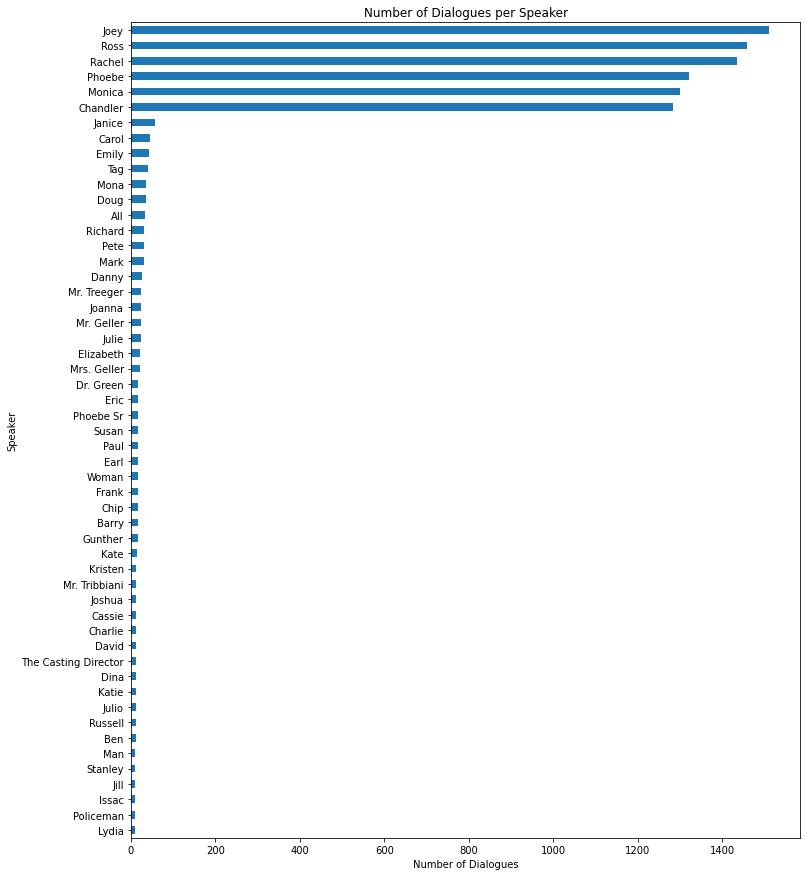

In [ ]:
print('Total Number of Speakers: {}'.format(len(df['Speaker'].unique())))
fig = plt.figure(figsize=(12, 15))
speaker_value_counts = df['Speaker'].value_counts().sort_values(ascending=True)
speaker_value_counts[speaker_value_counts > 10].plot(kind = 'barh')
plt.xlabel("Number of Dialogues")
plt.ylabel("Speaker")
plt.title("Number of Dialogues per Speaker")
plt.show()

# Preparing the Dataset

In [ ]:
# Let's create a list containing the main speakers
# We will use this to either grab or remove their faces from frames
# We will use facial_recognition for this which is a wrapper over dlib facial recognition
major_speakers = ['Joey', 'Ross', 'Rachel', 'Phoebe', 'Monica', 'Chandler']

### Setup

In [ ]:
def create_emotion_dirs(dir_name):
    emotions = df['Emotion'].unique()
    for emotion in emotions:
        dir_name = meld_path + '/face_train_splits/' + emotion
        re_create_dirs(dir_name)
        print('Created directory "{}" for emotion "{}"'.format(dir_name, emotion))

    dir_name = meld_path + '/face_train_splits/' + 'undefined'
    re_create_dirs(dir_name)
    print('Created directory "{}" for emotion "{}"'.format(dir_name, emotion))

def get_emotion(file):
    filename = file.split('/')[-1].split('.')[0]
    splitted = filename.split('_')
    dialogue = splitted[0]
    dialogue = [int(s) for s in re.findall(r'\d+', dialogue)][0]
    utterance = splitted[1]
    utterance = [int(s) for s in re.findall(r'\d+', utterance)][0]

    try:
        emotion = df[(df['Dialogue_ID'] == dialogue) & 
                    (df['Utterance_ID'] == utterance)]['Emotion'].iloc[0]
    except:
        emotion = 'undefined'
    
    return emotion

def get_speaker(file):
    filename = file.split('/')[-1].split('.')[0]
    splitted = filename.split('_')
    dialogue = splitted[0]
    dialogue = [int(s) for s in re.findall(r'\d+', dialogue)][0]
    utterance = splitted[1]
    utterance = [int(s) for s in re.findall(r'\d+', utterance)][0]

    try:
        speaker = df[(df['Dialogue_ID'] == dialogue) & 
                    (df['Utterance_ID'] == utterance)]['Speaker'].iloc[0]
    except:
        speaker = 'Unknown'
    
    return speaker

In [ ]:
# get_emotion(meld_path + '/train_splits/' + 'dia296_utt0.mp4')
get_speaker(meld_path + '/train_splits/' + 'dia296_utt0.mp4')

'Ross'

### Face Recognition

#### Declaring path

In [ ]:
face_train_path = base_path + 'Friends-face/Train'
face_test_path = base_path + 'Friends-face/Test'

#### Extracting facial features

In [ ]:
known_encodings = []
known_names = []

def get_face_features(path, name):
    image = face_recognition.load_image_file(path)
    face_features = face_recognition.face_encodings(image)
    if len(face_features) != 0:
        known_names.append(name)
        known_encodings.append(face_features[0])
        features = {}
        for i, feature in enumerate(face_features[0]):
            features["features_{}".format([i])] = feature
        
        return features
    
    return False

df_face = pd.DataFrame([])
people = [p for p in os.listdir(face_train_path) if os.path.isdir("{}/{}".format(face_train_path, p))]
for speaker in people:
    files = os.listdir("{}/{}".format(face_train_path, speaker))
    print("Processing {}".format(speaker))

    for file in files:
        name = file.split(' ')[0].capitalize()
        path = face_train_path + "/{}/{}".format(speaker, file)
        if path.endswith('.jpeg') or path.endswith('.jpg') or path.endswith('.png') or path.endswith('.gif'):
            row = get_face_features(path, name)
            if row:
                row['label'] = speaker
                df_face = df_face.append([row])
            else:
                print('No face found for Train/{}/{}'.format(speaker, file))
        else:
            print('No image file in /{}/{}'.format(speaker, file))

data_enc = {'encodings': known_encodings, 'names': known_names}
f = open(base_path + 'Friends-face/face_enc', 'wb')
f.write(pickle.dumps(data_enc))
f.close()

df_face.reset_index(drop=True, inplace=True)
df_face.head()

Processing Chandler
Processing Ross
Processing Rachel
Processing Phoebe
Processing Joey
Processing Monica


,features_[0],features_[1],features_[2],features_[3],features_[4],features_[5],features_[6],features_[7],features_[8],features_[9],...,features_[119],features_[120],features_[121],features_[122],features_[123],features_[124],features_[125],features_[126],features_[127],label
0,-0.170883,0.121940,0.019783,0.002243,-0.197132,-0.057859,0.023812,-0.180601,0.115739,-0.035569,...,0.030838,-0.032516,0.145538,-0.044210,-0.120619,0.074080,0.014234,0.039409,0.141411,Chandler
1,-0.158059,0.161935,0.072488,-0.026376,-0.204080,-0.094218,-0.041937,-0.080530,0.103607,-0.028576,...,0.016105,-0.042474,0.028332,-0.154167,-0.086552,0.096296,-0.028523,0.064775,0.067504,Chandler
2,-0.153146,0.122785,0.073606,0.001227,-0.190406,-0.043236,-0.005226,-0.067083,0.148696,-0.045434,...,0.020206,-0.030599,0.129306,-0.140236,-0.098316,0.015414,-0.030068,0.073614,0.141493,Chandler
3,-0.174099,0.102350,0.133694,0.009448,-0.141463,-0.048661,0.004600,-0.139358,0.130711,-0.024871,...,0.001145,-0.055098,0.083798,-0.062615,-0.079613,0.075647,-0.072750,0.073513,0.128921,Chandler
4,-0.186424,0.152597,0.119026,-0.053153,-0.193692,0.013849,-0.019806,-0.117700,0.112654,0.015079,...,0.029503,-0.029128,0.081301,-0.085245,-0.063653,0.018482,-0.062745,0.042710,0.144944,Chandler


#### Generating Facial Recognition Model using Random Forest

In [ ]:
#@title
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

X = df_face.drop(columns=['label'])
y = df_face['label']

le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2,
                                                    random_state=68)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
hyp = clf.predict(X_test)

df_prediction = pd.DataFrame({
    'prediction': le.inverse_transform(hyp),
    'actual': le.inverse_transform(y_test),
    'match': le.inverse_transform(hyp) == le.inverse_transform(y_test)
})
df_prediction.head()

,prediction,actual,match
0,Joey,Joey,True
1,Chandler,Chandler,True
2,Joey,Joey,True
3,Monica,Monica,True
4,Monica,Monica,True


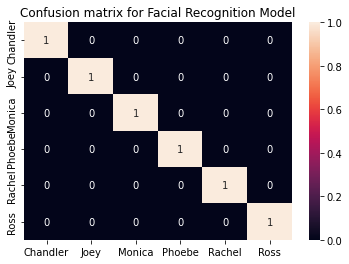

In [ ]:
#@title
# confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(le.inverse_transform(y_test), le.inverse_transform(hyp), normalize='true')
sns.heatmap(cm, annot=True, xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion matrix for Facial Recognition Model')
plt.show()

The prediction from the model are really good

In [ ]:
from PIL import Image

def get_predict_features(image, is_image):
    if not is_image:
        image = face_recognition.load_image_file(image)
    face_features = face_recognition.face_encodings(image)

    names = []

    for face_encoding in face_features:
        matches = face_recognition.compare_faces(data_enc['encodings'], face_encoding)
        name = 'Unknown'

        if True in matches:
            matched_idxs = [i for (i, b) in enumerate(matches) if b]
            counts = {}

            for i in matched_idxs:
                name = data_enc['names'][i]
                counts[name] = counts.get(name, 0) + 1
                name = max(counts, key=counts.get)
            names.append(name)

            # df_predicted = pd.DataFrame([])
            # for face_feature in face_features:
            #     features = {}
            #     for i, feat in enumerate(face_feature):
            #         features[f'feature_{i}'] = feat
            #     df_predicted = df_predicted.append([features])
            # return df_predicted
        else:
            names.append('Unknown')
    return names
        

def predict(path, is_image=False):
    X_predict = get_predict_features(path, is_image)
    if X_predict is None or len(X_predict) == 0:
        return []
    # y_predict = clf.predict(X_predict)
    # return le.inverse_transform(y_predict)
    return X_predict

def show_faces_in_picture(image):
    face_locations = face_recognition.face_locations(image)
    face_names = predict(image, True)
    print(face_names)
    face_crop = []
    if len(face_names):
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        for i, face in enumerate(face_locations):
            top, right, bottom, left = face
            fa = image[top:bottom, left:right]
            face_crop.append({'name': face_names[i], 'face': fa})
    
    fig = plt.figure(figsize=(5, 5))
    i = 1
    for fobj in face_crop:
        fig.add_subplot(2, 2, i)
        plt.imshow(fobj['face'])
        plt.title(fobj['name'])
        plt.axis('off')
        i += 1

def extract_speaker_face(image, dialogue_speaker):
    face_locations = face_recognition.face_locations(image)
    face_names = predict(image, True)
    face_crop = []
    if len(face_names):
        for i, face in enumerate(face_locations):
            top, right, bottom, left = face
            fa = image[top:bottom, left:right]

            if dialogue_speaker in major_speakers:
                if face_names[i] == dialogue_speaker:
                    face_crop.append({'name': face_names[i], 'face': fa})
            else:
                if face_names[i] not in major_speakers:
                    face_crop.append({'name': face_names[i], 'face': fa})

    return face_crop

### Testing

In [ ]:
def extract_speaker_face_all(image, dialogue_speaker):
    face_locations = face_recognition.face_locations(image)
    face_names = predict(image, True)
    face_crop = []
    if len(face_names):
        for i, face in enumerate(face_locations):
            top, right, bottom, left = face
            fa = image[top:bottom, left:right]

            if dialogue_speaker in major_speakers:
                    face_crop.append({'name': face_names[i], 'face': fa})
            else:
                if face_names[i] not in major_speakers:
                    face_crop.append({'name': face_names[i], 'face': fa})

    return face_crop

def get_frame(sec, vid_cap, count, filename):
    # since we are only selecting the middle frame now
    if count != 1:
      return None

    vid_cap.set(cv2.CAP_PROP_POS_MSEC, sec*1000)
    has_frames, image = vid_cap.read()
    emotion = get_emotion(filename)
    dialogue_speaker = get_speaker(filename)
    if has_frames:
        return image

    return None

Testing Face for DialogueID 770 and UtteranceID 2


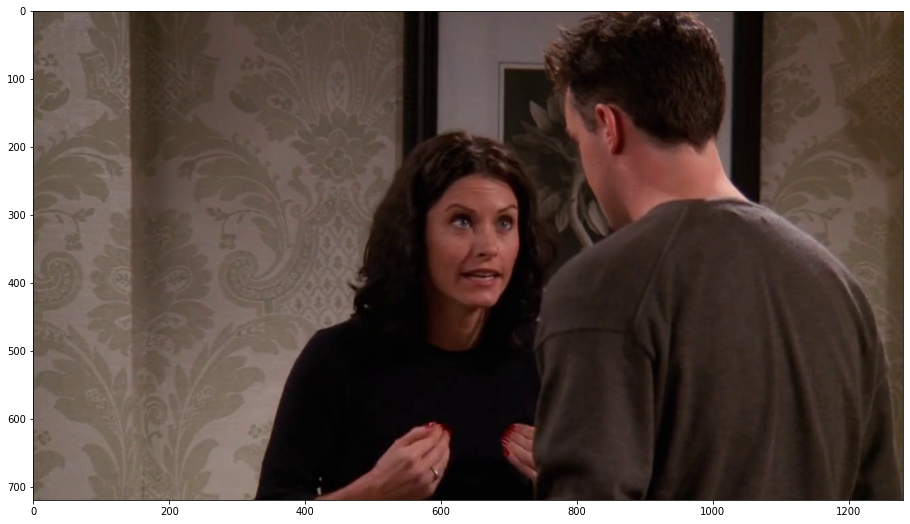

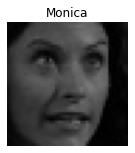

In [ ]:
#@title
print("Testing Face for DialogueID {} and UtteranceID {}".format(770, 2))

video_file = '{}/train_splits/dia770_utt2.mp4'.format(meld_path)

filename, ext = os.path.splitext(video_file)
vid_cap = cv2.VideoCapture(video_file)

frame_count = int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = vid_cap.get(cv2.CAP_PROP_FPS) 
filename = filename.split('/')[-1]

frames_req = 5

sec = 0
frame_rate = frame_count / (frames_req * fps)
count = 1

# print("Getting frames for {}".format(filename))
img = get_frame(sec, vid_cap, count, filename)

fig = plt.figure(figsize=(16, 9))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

test_img = meld_path + '/face_train_splits/anger/dia770_utt2_fr1_fa1.jpg'
# show_faces_in_picture(cv2.imread(test_img))
faces_obj = []
faces_obj = extract_speaker_face_all(cv2.imread(test_img), 'Chandler')

fig = plt.figure(figsize=(5, 5))
i = 1

if len(faces_obj) == 0:
    print('No face objects found')
else:
    for face_obj in faces_obj:
        fig.add_subplot(2, 2, i)

        face_obj_name = face_obj['name']
        face_obj_face = face_obj['face']
        
        plt.imshow(face_obj_face)
        plt.title(face_obj_name)
        plt.axis('off')
        i += 1

In [ ]:
df[(df['Dialogue_ID'] == 770) & (df['Utterance_ID'] == 2)]

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
7241,7651,And we're not a couple of suckers!,Monica,anger,negative,770,2,5,5,"00:08:15,912","00:08:17,871"


### Convert video into image

#### CV2 Haar Cascade Classifier

In [ ]:
# face_class = cv2.CascadeClassifier(meld_path + '/haarcascade_frontalface_default.xml')

# def face_extractor(image):
#     gimg = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     detected = face_class.detectMultiScale(gimg)
#     print('detected: ', detected)

#     faces = []
    
#     if detected == ():
#         return None
#     else:
#         for detected_img in detected:
#             x, y, w, h = detected_img
#             cimg = image[y:y+h, x:x+w]
#             faces.append(cimg)
#         return faces

# def get_faces(photo):
#     img = cv2.imread(photo)
#     cfaces = face_extractor(img)
#     retval = []
#     count = 1
#     if cfaces is not None:
#         count += 1
#         for cface in cfaces:
#             face = cv2.resize(cface, (48, 48))
#             face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
#             retval.append(face)
#         return retval
#     else:
#         return None

In [ ]:
# faces = get_faces(meld_path + '/face_train_splits/' + 'neutral/dia614_utt15.jpg')

# num_faces = len(faces)

# if num_faces == 1:
#     plt.imshow(face)
# else:
#     fig, ax = plt.subplots(num_faces, figsize=(10, 10))
#     i = 0

#     for face in faces:
#         ax[i].imshow(face)
#         i += 1

#### Hog Face Detector

In [ ]:
from dlib import get_frontal_face_detector
import time

hog_face_detector = get_frontal_face_detector()

def hog_detect_face(image, hog_face_detector, display = True):
    '''
    This function performs face(s) detection on an image using dlib hog face detector.
    Args:
        image:             The input image of the person(s) whose face needs to be detected.
        hog_face_detector: The hog face detection model required to perform the detection on the input image.
        display:           A boolean value that is if set to true the function displays the original input image, 
                           and the output image with the bounding boxes drawn and time taken written and returns nothing.
    Returns:
        output_image: A copy of input image with the bounding boxes drawn.
        results:      The output of the face detection process on the input image.
    '''
    # Get the height and width of the input image.
    height, width, _ = image.shape
    # Create a copy of the input image to draw bounding boxes on.
    output_image = image.copy()
    # Convert the image from BGR into RGB format.
    imgRGB = cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY)
    # Perform the face detection on the image.
    results = hog_face_detector(imgRGB, 0)

    faces = []

    # Loop through the bounding boxes of each face detected in the image.
    for bbox in results:    
        # Retrieve the left most x-coordinate of the bounding box.
        x1 = bbox.left()
        # Retrieve the top most y-coordinate of the bounding box.
        y1 = bbox.top()
        # Retrieve the right most x-coordinate of the bounding box.
        x2 = bbox.right()
        # Retrieve the bottom most y-coordinate of the bounding box.       
        y2 = bbox.bottom()

        cimg = imgRGB[y1:y2, x1:x2]
        try:
            cimg_resized = cv2.resize(cimg, (48, 48))
            cimg = cimg_resized
            faces.append(cimg)
            # Draw a rectangle around a face on the copy of the image using the retrieved coordinates.
            cv2.rectangle(output_image, pt1=(x1, y1), pt2=(x2, y2), color=(0, 255, 0), thickness=width//200)
        except:
            print("could not resize image!")
    
    
    # Check if the original input image and the output image are specified to be displayed.
    if display:
        # Display the original input image and the output image.
        plt.figure(figsize=[15,15])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output");plt.axis('off');
        
    # Otherwise
    else:
        # Return the output image and results of face detection.
        return faces

### Geting Faces From Image

In [ ]:
# Modify this to change the frames
frames_req = 5

def get_frame(sec, vid_cap, count, output_directory, filename, output_ext):
    # since we are only selecting the middle frame now
    # if count != 3 and count != 1 and count != 5:
    #   return True
    vid_cap.set(cv2.CAP_PROP_POS_MSEC, sec*1000)
    has_frames, image = vid_cap.read()
    emotion = get_emotion(filename)
    dialogue_speaker = get_speaker(filename)
    if has_frames:
        # TODO - we need to get all faces from the frame and write that
        faces = hog_detect_face(image, hog_face_detector, display=False)
        if faces is not None and len(faces) != 0:
            num_faces = len(faces)
            face_count = 1
            for face in faces:
                face_objs = []
                face_objs = extract_speaker_face(cv2.cvtColor(face, cv2.COLOR_GRAY2BGR), dialogue_speaker)
                if len(face_objs) > 0:
                    cv2.imwrite("{}{}/{}_fr{}_fa{}.{}".format(output_directory, 
                                                        emotion, 
                                                        filename,
                                                        count, 
                                                        face_count, 
                                                        output_ext), face)
                    face_count += 1
    return has_frames

def convert_video_to_frames(video_file, output_directory, output_ext="jpg"):
    """Converts video to multiple frames using OpenCV library"""
    filename, ext = os.path.splitext(video_file)
    vid_cap = cv2.VideoCapture(video_file)
    
    frame_count = int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = vid_cap.get(cv2.CAP_PROP_FPS) 
    filename = filename.split('/')[-1]
    
    if fps == 0 or frame_count == 0:
        print("No frames in {}. Skipping!".format(filename))
        return
    
    sec = 0
    frame_rate = frame_count / (frames_req * fps)
    count = 1
    
    # print("Getting frames for {}".format(filename))
    success = get_frame(sec, vid_cap, count, output_directory, filename, output_ext)
    
    while success:
        count = count + 1
        sec = sec + frame_rate
        sec = round(sec, 2)
        
        if count > frames_req:
            break
        
        success = get_frame(sec, vid_cap, count, output_directory, filename, output_ext)

def convert_all_videos(input_directory, output_directory):
    # Check if the directory exists, otherwise create directory
    try:
        if os.path.exists(output_directory):
            shutil.rmtree(output_directory)
        os.makedirs(output_directory)
        create_emotion_dirs(output_directory)
    except OSError:
        print('Error: Creating directory of data')
    
    i = 0
    
    for filename in os.listdir(input_directory):
        if i % 500 == 0:
            print('processed {} images'.format(i))
        f = os.path.join(input_directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            convert_video_to_frames(f, output_directory)
            i += 1

### Executing the function

In [ ]:
convert_all_videos('{}/train_splits/'.format(meld_path), '{}/face_train_splits/'.format(meld_path))

Created directory "/content/drive/MyDrive/ml-project/MELD.Raw/face_train_splits/neutral" for emotion "neutral"
Created directory "/content/drive/MyDrive/ml-project/MELD.Raw/face_train_splits/surprise" for emotion "surprise"
Created directory "/content/drive/MyDrive/ml-project/MELD.Raw/face_train_splits/fear" for emotion "fear"
Created directory "/content/drive/MyDrive/ml-project/MELD.Raw/face_train_splits/sadness" for emotion "sadness"
Created directory "/content/drive/MyDrive/ml-project/MELD.Raw/face_train_splits/joy" for emotion "joy"
Created directory "/content/drive/MyDrive/ml-project/MELD.Raw/face_train_splits/disgust" for emotion "disgust"
Created directory "/content/drive/MyDrive/ml-project/MELD.Raw/face_train_splits/anger" for emotion "anger"
Created directory "/content/drive/MyDrive/ml-project/MELD.Raw/face_train_splits/undefined" for emotion "anger"
processed 0 images
could not resize image!
could not resize image!
could not resize image!
could not resize image!
could not res

### Counting the number of Documents processed

In [ ]:
inp_dir = '{}/face_train_splits/'.format(meld_path)

def file_cnt(folder):
    "count the number of files in a directory"
    count = 0
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)

        if os.path.isfile(path):
            count += 1
        elif os.path.isdir(path):
            count += file_cnt(path)

    print('{} image files in "{}"'.format(count, folder.split('/')[-1]))
    return count

total_count = file_cnt(inp_dir)

11221 image files in "neutral"
2891 image files in "surprise"
674 image files in "fear"
1673 image files in "sadness"
3928 image files in "joy"
700 image files in "disgust"
2802 image files in "anger"
0 image files in "undefined"
23889 image files in ""


### Testing the images with dataframe

In [ ]:
did = 757
uid = 1

In [ ]:
df[(df['Dialogue_ID'] == did) & (df['Utterance_ID'] == uid)]

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
7142,7549,"Well uh, you and I are just goofing around, I ...",Monica,neutral,neutral,757,1,5,3,"00:18:04,083","00:18:09,253"


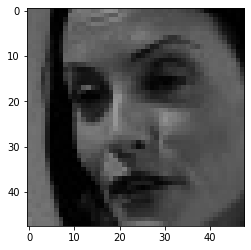

In [ ]:
test_face_img = cv2.imread(meld_path + '/face_train_splits/neutral/dia{}_utt{}_fr3_fa1.jpg'.format(did, uid))
plt.imshow(test_face_img)